In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv", "Fuzzy_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,0.014852,0.008606,0.015570,0.009878,0.001069,0.011646,0.112122,0.257314,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,0.019498,0.001095,0.011275,0.009880,0.009658,0.009361,0.009878,0.000904,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,0.009826,0.000248,0.000808,0.001119,0.000480,0.001412,0.000899,0.000248,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,0.038203,0.027087,0.009841,0.009859,0.009885,0.007653,0.000234,0.006513,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,0.009870,0.000475,0.000475,0.034847,0.000475,0.000475,0.000241,0.000475,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,0.328125,0.078125,0.000242,0.008995,0.799798,0.001008,0.001246,0.000242,0.000242,0.149000,0.001974,0.159987,0.219917,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,0.187500,0.000000,0.002922,0.049999,0.013848,0.002922,0.002922,0.002922,0.002922,0.003930,0.004168,0.003930,0.003930,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,0.296875,0.015625,0.000468,0.009935,0.019970,0.009935,0.009935,0.009935,0.003868,0.009935,0.018993,0.009418,0.000468,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,0.312500,0.000000,0.000250,0.009935,0.009935,0.000718,0.005135,0.000718,0.000718,0.000718,0.000718,0.000718,0.000250,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

df_original = df.copy()

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.071447,0.802552,15.392904,-0.036750,0.866375,0.679258,0.752510,1.520016,0.739186,-0.745310,0.336812,12.294366,5.007122,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.666667,0.121326,-0.763636,-0.038113,0.007093,1.187873,-0.080271,1.073441,0.739357,0.103380,0.088818,1.009430,-0.016261,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,-0.111111,-0.188528,0.454545,-0.034453,-0.037996,0.129111,-0.174169,-0.014896,-0.183885,-0.803486,-0.773887,0.018311,-0.029114,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,-0.222222,-0.092542,-0.600000,-0.036783,0.009647,3.235510,2.801496,0.924378,0.737136,0.125780,-0.096581,-0.055051,0.093618,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.111111,0.288797,-0.090909,-0.036783,-0.004068,0.133925,-0.149005,-0.049479,3.370414,-0.803981,-0.875589,-0.054314,-0.024667,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,-0.222222,0.800000,0.000000,-0.848121,0.962084,-0.836248,-0.063519,-0.073699,-0.276325,13.871166,-0.712881,17.577432,4.274467,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,-1.222222,-0.200000,204.363636,32.986819,-0.033112,-0.626742,0.122281,0.204933,0.006080,-0.462615,-0.474797,0.352859,0.043019,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,-0.444444,0.000000,17.236364,-0.072595,-0.025360,0.140993,0.899818,0.934110,0.105776,0.130718,1.134192,0.958606,-0.024803,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,-0.333333,-0.200000,0.618182,-0.072595,-0.038067,-0.867986,0.367661,-0.024194,-0.226150,-0.779953,-0.849195,-0.001632,-0.029072,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [5]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [6]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		12682		5436
Attack		12682		5436


In [7]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

Deep Neural Network

In [8]:
import keras
from keras import layers
# from tensorflow import keras
# from keras import layers

dnn = keras.models.Sequential(
    [
        layers.Dense(23, activation='relu', input_dim=len(X_train.columns)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)

val_percent = int(len(y_train) * 0.1)
X_val = X_train[-val_percent:]
y_val = y_train[-val_percent:]
X_train = X_train[:-val_percent]
y_train = y_train[:-val_percent]

dnn.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=3,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/3
714/714 [==============================] - 1s 1ms/step - loss: 0.2957 - binary_accuracy: 0.9397 - recall: 0.9739 - false_negatives: 265.0000 - val_loss: 0.0576 - val_binary_accuracy: 0.9894 - val_recall: 0.9894 - val_false_negatives: 27.0000
Epoch 2/3
714/714 [==============================] - 1s 942us/step - loss: 0.0575 - binary_accuracy: 0.9856 - recall: 0.9902 - false_negatives: 99.0000 - val_loss: 0.0518 - val_binary_accuracy: 0.9921 - val_recall: 0.9921 - val_false_negatives: 20.0000
Epoch 3/3
714/714 [==============================] - 1s 938us/step - loss: 0.0449 - binary_accuracy: 0.9894 - recall: 0.9926 - false_negatives: 75.0000 - val_loss: 0.0650 - val_binary_accuracy: 0.9917 - val_recall: 0.9917 - val_false_negatives: 21.0000


In [9]:
y_pred = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, y_pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, y_pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Testing F1:  0.9921(+/- 0.0000)
Kappa score:  0.9842(+/- 0.0000)


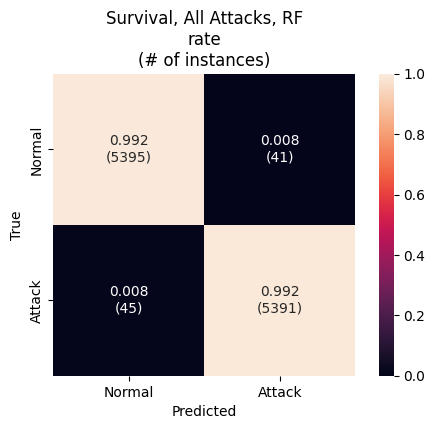

In [10]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [11]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train[-10:])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AttributeError: Exception encountered when calling layer "sequential_1" (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received:
  • inputs=['            dcs  dcs_ID         dt        dt_ID   dt_data      dt_d0  \\\n22818  0.777778     6.4  -1.600000  1467.011214  1.232376  10.400480   \n22819  0.666667     6.4  50.472727  1927.851662  1.232376  15.102730   \n22820  1.888889     7.4  67.036364   739.644108  1.232376  49.151746   \n22821  0.888889     6.0  -1.672727  7455.600433  1.232376  -0.483948   \n22822  1.222222     6.8  57.963636  1362.782609  1.232376  28.725949   \n22823  1.333333     7.4  56.890909   970.007476  1.232376  -0.559613   \n22824  0.888889     6.6   5.727273  2775.129311  1.232376  51.200234   \n22825  1.000000     6.2   6.090909    -2.917765  1.232376  14.963251   \n22826  0.555556     6.0   5.254545  5742.400748  1.232376  -0.659681   \n22827  1.000000     6.4  -1.672727   531.030691  1.232376  -0.225166   \n\n            dt_d1      dt_d2       dt_d3       dt_d4       dt_d5       dt_d6  \\\n22818   35.805186  34.654289    0.592648   20.108857   11.648502   57.790927   \n22819   14.205599  96.089291   10.477576   14.080306   -0.736118   27.537749   \n22820   24.956279  19.523699   26.762242   -0.529093   49.508487    4.133812   \n22821  588.208163  13.574343  547.934424  529.661461  642.352533  598.187390   \n22822   62.651265  20.980491    4.912465   -0.164806   61.023133    6.837215   \n22823   30.057307   0.891919    7.136027   19.253004    3.431377    3.117628   \n22824    9.461183  13.018171   63.961832   21.144335   24.837137   31.517513   \n22825    9.641537  22.513882    0.158991    0.585324    7.268928    7.066998   \n22826   24.048267   1.463659    5.976935   46.567939    7.494799   12.261519   \n22827   42.654305  26.534556    1.603377    0.888787    4.763831   44.694350   \n\n           dt_d7  \n22818   9.744093  \n22819   0.544086  \n22820  13.178960  \n22821   3.386790  \n22822   4.103923  \n22823   1.393915  \n22824   1.206897  \n22825   2.010643  \n22826   3.615458  \n22827   5.658839  ']
  • training=None
  • mask=None

In [13]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_train) - dnn.predict_proba(X_train)).max() < 1e-4

shap_all = get_explanation(exp, X_train, 100)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


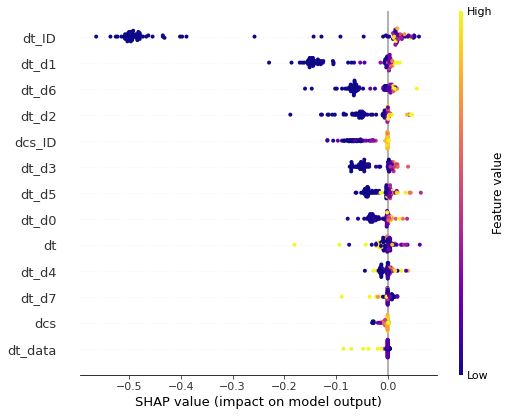

In [14]:
plot_beeswarm(shap_all)

In [15]:
plot_force(shap_all)

In [ ]:
plot_scatter(shap_all, "dt_ID")